## Table of contents

[**Section I**](#Section-I:-Preprocessing-data-files): Preprocessing data files

[**Section II**](#Section-II:-Feature-Engineering-and-Text-Preprocessing): Feature Engineering and Text Preprocessing

[**Section III**](#Section-III:-Modelling): Modelling

In [68]:
!pip install tweet-preprocessor
!pip install wordcloud

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 20 bytes


In [0]:
!pip install -r requirements.txt

In [69]:
from collections import Counter
from datetime import datetime
import json
# import jsonpickle
import os
import pickle
import re
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import FreqDist, word_tokenize
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
import preprocessor as p
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
%load_ext autoreload
%autoreload 1

sys.path.append("../../src/")

# from d01_data.data_processing import *
# from d02_features.text_preprocessing import *
from d03_models.modelling_functions import *
from d04_visualisation.building_charts import *

# %aimport d01_data.data_processing
# %aimport d02_features.text_preprocessing
%aimport d03_models.modelling_functions
%aimport d04_visualisation.building_charts

In [0]:
def add_column_from_regex(df, pattern, old_col, new_colname, strip=False):
    """
    Create a new column to add to a dataframe, by applying a regex pattern 
    to an existing column.
    
    Parameters
    ----------
        df : a dataframe of tweets
        pattern : a regex pattern, used to create the new column (formatted string)
        old_col : the name of the old column (string)
        new_colname : the name of the new column to add (string)
    
    Returns
    -------
        None. 
    """
    pattern = re.compile(pattern)
    df[new_colname] = df[old_col].apply(lambda x: re.findall(pattern, x))

    if strip == True:
        df[old_col] = df[old_col].apply(lambda x: re.sub(pattern, '', x))

def add_count_column(df, old_col):
    """
    Create a new column that counts the number of instances in another column.
    
    Parameters
    ----------
        df : a dataframe of tweets
        old_col : the name of the old column (string)
        new_colname : the name of the new column to add (string)
    
    Returns
    -------
        None. 

    """
    new_colname = old_col + '_count'
    df[new_colname] = df[old_col].apply(lambda x: len(x))



# functions for parsing text from tweets

def parse_urls(tweet):
    """
    Parses a tweet for URLs.
    
    Parameters
    ----------
        tweet : the text of a tweet.
        
    Returns
        A list of parsed URLs (or an empty list).
    """
    parsed_tweet = p.parse(tweet)
    if parsed_tweet.urls == None:
        return []
    else:
        return [x.match for x in parsed_tweet.urls]

def parse_mentions(tweet):
    """
    Parses a tweet for mentions.
    
    Parameters
    ----------
        tweet : the text of a tweet.
        
    Returns
        A list of parsed mentions (or an empty list).
    """
    parsed_tweet = p.parse(tweet)
    if parsed_tweet.mentions == None:
        return []
    else:
        return [x.match for x in parsed_tweet.mentions]

def parse_hashtags(tweet):
    """
    Parses a tweet for hashtags.
    
    Parameters
    ----------
        tweet : the text of a tweet.
        
    Returns
        A list of parsed hashtags (or an empty list).
    """
    parsed_tweet = p.parse(tweet)
    if parsed_tweet.hashtags == None:
        return []
    else:
        return [x.match for x in parsed_tweet.hashtags]

def parse_reserved_words(tweet):
    """
    Parses a tweet for reserved words ("RT" or "FAV").
    
    Parameters
    ----------
        tweet : the text of a tweet.
        
    Returns
        A list of parsed reserved words (or an empty list).
    """
    parsed_tweet = p.parse(tweet)
    if parsed_tweet.reserved == None:
        return []
    else:
        return [x.match for x in parsed_tweet.reserved]

def parse_emojis(tweet):
    """
    Parses a tweet for emojis.
    
    Parameters
    ----------
        tweet : the text of a tweet.
        
    Returns
        A list of parsed emojis (or an empty list).
    """
    parsed_tweet = p.parse(tweet)
    if parsed_tweet.emojis == None:
        return []
    else:
        return [x.match for x in parsed_tweet.emojis]

def parse_smileys(tweet):
    """
    Parses a tweet for smiley faces.
    
    Parameters
    ----------
        tweet : the text of a tweet.
        
    Returns
        A list of parsed smiley faces (or an empty list).
    """
    parsed_tweet = p.parse(tweet)
    if parsed_tweet.smileys == None:
        return []
    else:
        return [x.match for x in parsed_tweet.smileys]

def parse_numbers(tweet):
    """
    Parses a tweet for numbers.
    
    Parameters
    ----------
        tweet : the text of a tweet.
        
    Returns
        A list of parsed numbers (or an empty list).
    """
    parsed_tweet = p.parse(tweet)
    if parsed_tweet.numbers == None:
        return []
    else:
        return [x.match for x in parsed_tweet.numbers]



# functions for processing text from tweets

def remove_punctuation(tweet):
    """
    Removes punctuation from the text of a tweet.
    """
    pattern = re.compile(r'[^\w\s]')  
    clean_tweet =  re.sub(pattern, '', tweet).strip()
    return clean_tweet

def calc_pct_upper(tweet):
    """
    Calculates the percantage of a tweet's uppercase letters. 
    """
    clean_text = re.sub(r"\s+", "", tweet)  # remove whitespace
    numer = sum(1 for c in clean_text if c.isupper())  # number of upper chars
    denom = len(clean_text)  # number of total chars
    if denom != 0:
        return numer/denom
    else: 
        return 0

def process_tweet(tweet):
    """
    Process the text of a tweet, by the text to lowercase, 
    stripping leading and whitespace, tokenizing and removing stop words. 

    Parameters
    ----------
        tweet : the content (text) of a tweet (string)

    Returns
    -------
        clean_tweet : the cleaned content (text) of a tweet
    """
    stop_words = set(stopwords.words('english'))
    clean_tweet = tweet.lower().strip()  # lowercase, strip whitespace
    clean_tweet = word_tokenize(clean_tweet)  # tokenize
    clean_tweet = [w for w in clean_tweet if not w in stop_words]  # remove stop words
    return clean_tweet

def get_wordnet_pos(treebank_tag):
    """
    Returns the WordNet part of speech for each Tree Bank tag.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 

def lemmatize_tokens(tweet_tokens):
    """
    Lemmatizes the (already) tokenized text of a tweet.

    Parameters
    ----------
        tweet_tokens : the tokenized and cleaned text of a tweet (list)

    Returns:
        lem_result : a list of lemmatized tokens
    """
    lemmatizer = WordNetLemmatizer()
    tags = nltk.pos_tag(tweet_tokens)
    tags_word_net = [get_wordnet_pos(w[1]) for w in tags]
    lem_result = []  
    for i in range(len(tags_word_net)):
        if tags_word_net[i]:  
            lem_result.append(lemmatizer.lemmatize(tags[i][0],tags_word_net[i]))
        else:
            lem_result.append(tags[i][0])
    return lem_result

def add_clean_text_numeric_and_regex_features(df):
    """
    Appends numeric features and features created using regular expressions
    to a dataframe of tweet text, as well as cleaned-up tweet text. 
    
    Parameters
    ----------
        df : a dataframe containing a column labeled "content", 
             containing the content of a tweet
    
    Returns
    -------
        None. Prints shapes of the original and new dataframes. 
    """
    print('Original shape:', df.shape)
    # add features using twitter-preprocessor
    df['urls'] = df.content.apply(parse_urls)
    df['mentions'] = df.content.apply(parse_mentions)
    df['hashtags'] = df.content.apply(parse_hashtags)
    df['reserved_words'] = df.content.apply(parse_reserved_words)
    df['emojis'] = df.content.apply(parse_emojis)
    # df['numbers'] = df.content.apply(parse_numbers)
    
    # add count features
    add_count_column(df=df, old_col='urls')
    add_count_column(df=df, old_col='mentions')
    add_count_column(df=df, old_col='hashtags')
    add_count_column(df=df, old_col='reserved_words')
    add_count_column(df=df, old_col='emojis')
    # add_count_column(df=df, old_col='numbers')
    
    # clean tweet content
    df['content_clean'] = df.content.apply(lambda x: p.clean(x))
    df['content_clean'] = df.content_clean.apply(remove_punctuation)
    
    # add feature for count of words in a tweet
    df['word_count'] = df.content_clean.apply(lambda x: len(word_tokenize(x)))
    
    # add feature for percent of characters that are uppercase
    df['pct_upper'] = df.content_clean.apply(calc_pct_upper)
    
    # add features by regex (from 'content_clean')
    add_column_from_regex(df=df, pattern=r'(\!)', 
                          old_col='content_clean', new_colname='exclams')
    add_column_from_regex(df=df, pattern=r'(\?)',
                          old_col='content_clean', new_colname='ques_marks')
    add_column_from_regex(df=df, pattern=r'(\$)',
                          old_col='content_clean', new_colname='dollar_marks')
    # add_column_from_regex(df=df, pattern=r'\d+', 
    #                       old_col='content_clean', new_colname='number', strip=True)

    # add features by regex (from 'content')
    add_column_from_regex(df=df, pattern=r'pic.twitter.com[^\s]+', 
                          old_col='content', new_colname='pics', strip=True)
    
    # add count features
    add_count_column(df=df, old_col='exclams')
    add_count_column(df=df, old_col='ques_marks')
    add_count_column(df=df, old_col='dollar_marks')
    # add_count_column(df=df, old_col='number')
    add_count_column(df=df, old_col='pics')
    
    # process tweet content
    df['content_tokenized'] = df.content_clean.apply(process_tweet)

    # lemmatize tweet tokens
    df['content_tokenized_lemma'] = df.content_tokenized.apply(lemmatize_tokens)
    
    # join tokens back into a string
    df['content_tokenized_lemma_joined'] = df.content_tokenized_lemma.apply(lambda x: " ".join(x))
    df.content_tokenized_lemma_joined = df.content_tokenized_lemma_joined.fillna(value='')

    df['emojis_joined'] = df.emojis.apply(lambda x: " ".join(x))
    df['hashtags_joined'] = df.hashtags.apply(lambda x: " ".join(x))

    # filter out columns i don't need
    df = df[[
     'target',
     'urls_count',
     'mentions_count',
     'hashtags_count',
     'reserved_words_count',
     'emojis_count',
     'word_count',
     'pct_upper',
     'exclams_count',
     'ques_marks_count',
     'dollar_marks_count',
     'pics_count',
     'content_tokenized_lemma_joined',
     'emojis_joined',
     'hashtags_joined'
    ]]
    
    print('New shape:', df.shape)


In [0]:
def validate_train_test_split(df, test_size, validation_size, random_state):
    """
    Split dataframes into a train, test and validation datasets.
    Achieves this by first splitting the dataframe into a training and testing dataset,
    and then carves out a subset of the training data to use for validation.
    
    Parameters
    ----------
        df : dataframe to split 
        test_size: percent of data to use in the training dataset
        validation_size : the percent of training data to hold out as a validation set
        random_state : random seed to generate the two splits
        
    Returns
    -------
        train, test, validation (dataframes)
    """
    training_data, test = train_test_split(df, test_size=test_size, random_state=random_state)
    train, validation = train_test_split(training_data, test_size=validation_size, random_state=random_state)
    print('Train shape:', train.shape)
    print('Test shape:', test.shape)
    print('Validation shape:', validation.shape)
    return train, test, validation

def generate_unbalanced_X_and_y(df, pos_class_size, random_state):
    """
    Generate a feature matrix X and target vector y with artificially 
    unbalanced classes through downsampling, where the minority class 
    is equal to a user-specified share of the majority class.
    
    Parameters
    ----------
        df : the dataframe with balanced classes (to be split into X and y); target feature
             must be labeled as "target"
        pos_class_size : the percentage of the positive class to retain, as a share of 
             the negative class (fraction between 0 and 1)
        random_state : random seed to generate the downsampling of the positive class
        
    Returns
    -------
        X, y
    """
    print('Original shape:', df.shape)

    # generate X
    X_neg = df[df.target == 0].drop(['target'], axis=True)
    print('X negative rows:', X_neg.shape)
    X_pos = df[df.target == 1].drop(['target'], axis=True).sample(n=round(len(X_neg)*pos_class_size), random_state=random_state)
    print(f'X positive rows {pos_class_size*100}% sample:', X_pos.shape)
    X = pd.concat([X_neg, X_pos], axis=0, sort=False)
    print('X new:', X.shape)
    
    # generate y
    y_neg = df[df.target == 0]['target']
    print('y negative rows:', y_neg.shape)
    y_pos = df[df.target == 1]['target'].sample(n=round(len(y_neg)*pos_class_size), random_state=random_state)
    print(f'y positive rows {pos_class_size*100}% sample:', y_pos.shape)
    y = pd.concat([y_neg, y_pos], axis=0, sort=False)
    print('y new:', y.shape)
    
    return X, y



def generate_word_vector_for_X(X_train, X_test, X_valid, tweet_colname, max_features, stop_words):
    """
    Generate vectors of words from the text content of tweets, from three separate input 
    vectors for X (X_train, X_test and X_valid).
    
    Parameters
    ----------
        X_train : a feature matrix X for training that includes a column containing the text of tweets
        X_test : a feature matrix X for testing that includes a column containing the text of tweets
        X_valid : a feature matrix X for validation that includes a column containing the text of tweets
        tweet_colname : the name of the column that contains the text of tweets (string)
        max_features : the number of words to include in the vocabulary, only considering
            the top words ordered by term frequency across the corpus
    
    Returns
    -------
        X_train_content_feat, X_test_content_feat, X_valid_content_feat

    """
    vectorizer = TfidfVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 max_features = max_features,
                                 stop_words = stop_words,
                                 ngram_range = (1, 3))
    X_train_content = X_train[tweet_colname].tolist()
    X_test_content = X_test[tweet_colname].tolist()
    X_valid_content = X_valid[tweet_colname].tolist()
    
    X_train_content_feat = vectorizer.fit_transform(X_train_content).toarray()
    X_train_content_feat = pd.DataFrame(X_train_content_feat, columns=vectorizer.get_feature_names())

    X_test_content_feat = vectorizer.transform(X_test_content).toarray()
    X_test_content_feat = pd.DataFrame(X_test_content_feat, columns=vectorizer.get_feature_names())
    
    X_valid_content_feat = vectorizer.transform(X_valid_content).toarray()
    X_valid_content_feat = pd.DataFrame(X_valid_content_feat, columns=vectorizer.get_feature_names())

    print('Word vector')
    print('Train:', X_train_content_feat.shape)
    print('Test:', X_test_content_feat.shape)
    print('Valid:', X_valid_content_feat.shape)

    return X_train_content_feat, X_test_content_feat, X_valid_content_feat  

def generate_emoji_vector_for_X(X_train, X_test, X_valid, emoji_colname, max_features):
    """
    Generate vectors of emojis from tweets, from three separate input 
    vectors for X (X_train, X_test and X_valid).
    
    Parameters
    ----------
        X_train : a feature matrix X for training that includes a column containing emojis
        X_test : a feature matrix X for testing that includes a column containing emojis
        X_valid : a feature matrix X for validation that includes a column containing emojis
        emoji_colname : the name of the column that contains emojis (string)
        max_features : the number of emojis to include in the vocabulary, only considering
            the top emojis ordered by term frequency across the corpus
    
    Returns
    -------
        X_train_emoji_feat, X_test_emoji_feat, X_valid_emoji_feat

    """
    vectorizer = TfidfVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
    #                              stop_words = 'english',
                                 max_features = max_features,
    #                              ngram_range = (1, 3),
                                 token_pattern=r'[^\s]+')
    X_train_emoji = X_train[emoji_colname].tolist()
    X_test_emoji = X_test[emoji_colname].tolist()
    X_valid_emoji = X_valid[emoji_colname].tolist()
    
    X_train_emoji_feat = vectorizer.fit_transform(X_train_emoji).toarray()
    X_train_emoji_feat = pd.DataFrame(X_train_emoji_feat, columns=vectorizer.get_feature_names())

    X_test_emoji_feat = vectorizer.transform(X_test_emoji).toarray()
    X_test_emoji_feat = pd.DataFrame(X_test_emoji_feat, columns=vectorizer.get_feature_names())
    
    X_valid_emoji_feat = vectorizer.transform(X_valid_emoji).toarray()
    X_valid_emoji_feat = pd.DataFrame(X_valid_emoji_feat, columns=vectorizer.get_feature_names())

    print('Emoji vector')
    print('Train:', X_train_emoji_feat.shape)
    print('Test:', X_test_emoji_feat.shape)
    print('Valid:', X_valid_emoji_feat.shape)

    return X_train_emoji_feat, X_test_emoji_feat, X_valid_emoji_feat  

def generate_hashtag_vector_for_X(X_train, X_test, X_valid, hashtag_colname, max_features):
    """
    Generate vectors of hashtags from tweets, from three separate input 
    vectors for X (X_train, X_test and X_valid).
    
    Parameters
    ----------
        X_train : a feature matrix X for training that includes a column containing hashtags
        X_test : a feature matrix X for testing that includes a column containing hashtags
        X_valid : a feature matrix X for validation that includes a column containing hashtags
        hashtag_colname : the name of the column that contains hashtags (string)
        max_features : the number of hashtags to include in the vocabulary, only considering
            the top hashtags ordered by term frequency across the corpus
    
    Returns
    -------
        X_train_hashtag_feat, X_test_hashtag_feat, X_valid_hashtag_feat

    """
    vectorizer = TfidfVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
    #                              stop_words = 'english',
                                 max_features = max_features,
    #                              ngram_range = (1, 3),
                                 token_pattern=r'[^\s]+')
    X_train_hashtag = X_train[hashtag_colname].tolist()
    X_test_hashtag = X_test[hashtag_colname].tolist()
    X_valid_hashtag = X_valid[hashtag_colname].tolist()
    
    X_train_hashtag_feat = vectorizer.fit_transform(X_train_hashtag).toarray()
    X_train_hashtag_feat = pd.DataFrame(X_train_hashtag_feat, columns=vectorizer.get_feature_names())

    X_test_hashtag_feat = vectorizer.transform(X_test_hashtag).toarray()
    X_test_hashtag_feat = pd.DataFrame(X_test_hashtag_feat, columns=vectorizer.get_feature_names())
    
    X_valid_hashtag_feat = vectorizer.transform(X_valid_hashtag).toarray()
    X_valid_hashtag_feat = pd.DataFrame(X_valid_hashtag_feat, columns=vectorizer.get_feature_names())

    print('Hashtag vector')
    print('Train:', X_train_hashtag_feat.shape)
    print('Test:', X_test_hashtag_feat.shape)
    print('Valid:', X_valid_hashtag_feat.shape)

    return X_train_hashtag_feat, X_test_hashtag_feat, X_valid_hashtag_feat  

def generate_numeric_vector_for_X(X_train, X_test, X_valid, numeric_features):
    """
    Generate vectors of numeric features from tweets, from three separate input 
    vectors for X (X_train, X_test and X_valid).
    
    Parameters
    ----------
        X_train : a feature matrix X for training
        X_test : a feature matrix X for testing
        X_valid : a feature matrix X for validation
        numeric_features : numeric features to keep (list)
    
    Returns
    -------
        X_train_numeric_feat, X_test_numeric_feat, X_valid_numeric_feat
    """
    X_train_numeric = X_train[numeric_features]
    X_test_numeric = X_test[numeric_features]
    X_valid_numeric = X_valid[numeric_features]
    
    scaler = StandardScaler()
    X_train_numeric_feat = pd.DataFrame(scaler.fit_transform(X_train_numeric), 
                                        columns=X_train_numeric.columns)
    X_test_numeric_feat = pd.DataFrame(scaler.transform(X_test_numeric), 
                                        columns=X_test_numeric.columns)
    X_valid_numeric_feat = pd.DataFrame(scaler.transform(X_valid_numeric), 
                                        columns=X_valid_numeric.columns)
    print('Numeric vector')
    print('Train:', X_train_numeric_feat.shape)
    print('Test:', X_test_numeric_feat.shape)
    print('Valid:', X_valid_numeric_feat.shape)
    
    return X_train_numeric_feat, X_test_numeric_feat, X_valid_numeric_feat

def generate_combined_features_X(X_train, X_test, X_valid):
    """
    Combine vectors of words, emojis, hashtags and numeric features 
    into one dataframe of predictors for modelling. 

    Returns
    -------
        X_train_combo, X_test_combo, X_valid_combo

    """
    # content
    X_train_content_feat, X_test_content_feat, X_valid_content_feat = generate_word_vector_for_X(
                X_train, 
                X_test, 
                X_valid, 
                tweet_colname='content_tokenized_lemma_joined',
                max_features=300,
                stop_words=['american', 'obamas', 'supporter', 'thanks']
    )
    
    # emoji
    X_train_emoji_feat, X_test_emoji_feat, X_valid_emoji_feat = generate_emoji_vector_for_X(
                X_train, 
                X_test, 
                X_valid, 
                emoji_colname='emojis_joined',
                max_features=200
    )
    
    # hashtag
    X_train_hashtag_feat, X_test_hashtag_feat, X_valid_hashtag_feat = generate_hashtag_vector_for_X(
                X_train, 
                X_test, 
                X_valid, 
                hashtag_colname='hashtags_joined',
                max_features=300
    )
    
    # numeric
    numeric_features = [
     'urls_count',
     'mentions_count',
     'hashtags_count',
     'reserved_words_count',
     'emojis_count',
     'word_count',
     'pct_upper',
     'exclams_count',
     'ques_marks_count',
     'dollar_marks_count',
     'pics_count',
    ]
    
    X_train_numeric_feat, X_test_numeric_feat, X_valid_numeric_feat = generate_numeric_vector_for_X(
                X_train, 
                X_test, 
                X_valid, 
                numeric_features=numeric_features
    )
    
    # concat train, text and valid together
    print('---X_train report---')
    print(X_train_content_feat.shape)
    print(X_train_emoji_feat.shape)
    print(X_train_hashtag_feat.shape)
    print(X_train_numeric_feat.shape)
    X_train_combo = pd.concat([X_train_content_feat, X_train_emoji_feat,
                              X_train_hashtag_feat, X_train_numeric_feat], axis=1, sort=False)
    print('Combined shape:', X_train_combo.shape)
    
    print('---X_test report---')
    print(X_test_content_feat.shape)
    print(X_test_emoji_feat.shape)
    print(X_test_hashtag_feat.shape)
    print(X_test_numeric_feat.shape)
    X_test_combo = pd.concat([X_test_content_feat, X_test_emoji_feat,
                              X_test_hashtag_feat, X_test_numeric_feat], axis=1, sort=False)
    print('Combined shape:', X_test_combo.shape)

    print('---X_valid report---')
    print(X_valid_content_feat.shape)
    print(X_valid_emoji_feat.shape)
    print(X_valid_hashtag_feat.shape)
    print(X_valid_numeric_feat.shape)
    X_valid_combo = pd.concat([X_valid_content_feat, X_valid_emoji_feat,
                              X_valid_hashtag_feat, X_valid_numeric_feat], axis=1, sort=False)
    print('Combined shape:', X_valid_combo.shape)
    
    return X_train_combo, X_test_combo, X_valid_combo

## Section I: Preprocessing data files

### Dataset #1: Russian troll tweets

Process raw Russian tweets data into `RightTroll` subset, filtering down to rows and columns of interest

In [0]:
# process_files_into_right_trolls(num_of_files=13, chunksize=50000)
# create_combined_right_troll_csv(new_filepath='../../data/02_intermediate/right_trolls_all.csv')
# trim_right_trolls_csv(orig_filepath='../../data/02_intermediate/right_trolls_all.csv', 
#                        new_filepath='../../data/02_intermediate/right_trolls_trimmed.csv')

Read in `right_trolls_trimmed.csv`

In [0]:
# right_trolls = pd.read_csv('../../data/02_intermediate/right_trolls_trimmed.csv', parse_dates=[2])
# print(right_trolls.shape)
# right_trolls.head()

### Dataset #2: Verified tweets

Process verified tweets collected using `twint` (queried using specific hashtags, and not) into one file

In [0]:
# create_verified_tweets_csv(new_filepath='../../data/02_intermediate/verified_tweets.csv')

Read in `verified_tweets.csv`

In [0]:
# verified_tweets = pd.read_csv('../../data/02_intermediate/verified_tweets.csv', parse_dates=[2])
# print(verified_tweets.shape)
# verified_tweets.head()

Issue with a lot of major accounts being followed...

In [0]:
# verified_tweets.author.value_counts().head(50)

### Combine datasets 

In [0]:
# create_tweets_all_csv(path_to_right_trolls='../../data/02_intermediate/right_trolls_trimmed.csv',
#                       path_to_verified_tweets='../../data/02_intermediate/verified_tweets.csv',
#                       new_filepath='../../data/02_intermediate/tweets_all.csv',
#                       random_state=123)

Read in `tweets_all.csv`

In [0]:
# tweets_all = pd.read_csv('tweets_all.csv', parse_dates=[2])
# print(tweets_all.shape)
# tweets_all.head()

(343582, 4)


,author,content,publish_date,target
0,PAMELA_MOORE13,"Dave Chappelle: ""Black Lives Matter"" is the wo...",2016-08-31 01:49:00,1
1,TEN_GOP,Thoughts and prayers for anyone affected by th...,2017-02-07 21:41:00,1
2,BEETTYBECKS,BREAKING : Antifa Members Surrender to Police ...,2017-08-18 06:09:00,1
3,TEN_GOP,.@GovMikeHuckabee: 'Have to Believe in Unicorn...,2016-12-13 15:17:00,1
4,POLITWEECS,An ex-French prime minister's daughter posed t...,2015-07-12 16:24:00,1


## Section II: Feature Engineering and Text Preprocessing

#### Testing on a small batch

In [0]:
test_df = tweets_all.sample(n=50000, random_state=123)
print(test_df.shape)
test_df.head()

#### Preprocessing

In [0]:
# tweets_all = add_clean_text_numeric_and_regex_features(tweets_all)

Original shape: (343582, 4)
New shape: (343582, 15)


In [0]:
tweets_all.shape

(343582, 30)

In [0]:
tweets_all = tweets_all[[
 'target',
 'urls_count',
 'mentions_count',
 'hashtags_count',
 'reserved_words_count',
 'emojis_count',
 'word_count',
 'pct_upper',
 'exclams_count',
 'ques_marks_count',
 'dollar_marks_count',
 'pics_count',
 'content_tokenized_lemma_joined',
 'emojis_joined',
 'hashtags_joined'
]]

In [0]:
tweets_all.shape

(343582, 15)

In [0]:
tweets_all.head()

,target,urls_count,mentions_count,hashtags_count,reserved_words_count,emojis_count,word_count,pct_upper,exclams_count,ques_marks_count,dollar_marks_count,pics_count,content_tokenized_lemma_joined,emojis_joined,hashtags_joined
0,1,1,0,0,0,0,18,0.100000,0,0,0,0,dave chappelle black life matter bad slogan iv...,,
1,1,1,0,1,0,0,11,0.036364,0,0,0,0,thought prayer anyone affect tornado stay safe,,#NewOrleans
2,1,2,0,1,0,0,11,0.266667,0,0,0,0,break antifa member surrender police chant lik...,,#backk
3,1,1,1,0,0,0,11,0.137931,0,0,0,0,believe unicorns think russia change election ...,,
4,1,1,1,0,0,0,11,0.029851,0,0,0,0,exfrench prime minister daughter posed topless...,,


#### Save `tweets_all_feats`

In [0]:
# tweets_all.to_pickle('tweets_all_feats.pkl')

Save this 50K testing sample

In [0]:
# test_df.to_pickle('../../data/02_intermediate/testing_sample_50k_allfeat.pkl')

#### Read in `testing_sample_50k_allfeat.pkl`

In [0]:
# test_df = pd.read_pickle('../../data/02_intermediate/testing_sample_50k_allfeat.pkl')
# test_df.shape

(50000, 30)

## Section III: Modelling

### Train test split

I want classes to be balanced in the *training* data, but I want to make the *testing* data to be artificially imbalanced (mimicing real world conditions)

In [0]:
# train, test, validate = validate_train_test_split(tweets_all, test_size=0.1, validation_size=0.2, random_state=123)

Train shape: (247378, 15)
Test shape: (34359, 15)
Validation shape: (61845, 15)


Define `X_train` and `y_train`

In [0]:
# X_train = train.drop(['target'], axis=True)
# y_train = train['target']

# print(X_train.shape)
# print(y_train.shape)

(247378, 14)
(247378,)


Define `X_test` and `y_test`

In [0]:
# X_test, y_test = generate_unbalanced_X_and_y(test, pos_class_size=0.1, random_state=123)

Original shape: (34359, 15)
X negative rows: (17215, 14)
X positive rows 10.0% sample: (1722, 14)
X new: (18937, 14)
y negative rows: (17215,)
y positive rows 10.0% sample: (1722,)
y new: (18937,)


Define `X_valid` and `y_valid`

In [0]:
# X_valid, y_valid = generate_unbalanced_X_and_y(validate, pos_class_size=0.1, random_state=123)

Original shape: (61845, 15)
X negative rows: (30883, 14)
X positive rows 10.0% sample: (3088, 14)
X new: (33971, 14)
y negative rows: (30883,)
y positive rows 10.0% sample: (3088,)
y new: (33971,)


### Create my final `X` dataset

Which will be a combination of 4 vectors:

1. word vector : `_content`
2. emoji vector : `_emoji`
3. hashtag vector : `_hashtag`
4. "counts" vector (of numeric data) : `_numeric`

#### Combine 4 vectors together into `X_train_combo` and `X_test_combo`

In [0]:
# X_train_combo, X_test_combo, X_valid_combo = generate_combined_features_X(X_train, X_test, X_valid)

Word vector
Train: (247378, 300)
Test: (18937, 300)
Valid: (33971, 300)
Emoji vector
Train: (247378, 200)
Test: (18937, 200)
Valid: (33971, 200)
Hashtag vector
Train: (247378, 300)
Test: (18937, 300)
Valid: (33971, 300)
Numeric vector
Train: (247378, 11)
Test: (18937, 11)
Valid: (33971, 11)
---X_train report---
(247378, 300)
(247378, 200)
(247378, 300)
(247378, 11)
Combined shape: (247378, 811)
---X_test report---
(18937, 300)
(18937, 200)
(18937, 300)
(18937, 11)
Combined shape: (18937, 811)
---X_valid report---
(33971, 300)
(33971, 200)
(33971, 300)
(33971, 11)
Combined shape: (33971, 811)


### Free up some memory

In [0]:
del(test_df)
del(train)
del(test)
del(validate)
del(X_train)
del(X_test)
del(X_valid)

### Save X and y to `data/03_processed/`

In [0]:
# X_train_combo.to_pickle('X_train.pkl')
# X_test_combo.to_pickle('X_test.pkl')
# y_train.to_pickle('y_train.pkl')
# y_test.to_pickle('y_test.pkl')

### Save validation datasets to `data/03_processed/`

In [0]:
# X_valid_combo.to_pickle('X_validation.pkl')
# y_valid.to_pickle('y_validation.pkl')

In [0]:
# del(X_valid_combo)
# del(y_valid)

In [0]:
# X_train = pd.read_pickle('X_train_50k.pkl')
# X_test = pd.read_pickle('X_test_50k.pkl')
# y_train = pd.read_pickle('y_train_50k.pkl')
# y_test = pd.read_pickle('y_test_50k.pkl')

# X_train = pd.read_pickle('X_train.pkl')
# X_test = pd.read_pickle('X_test.pkl')
# y_train = pd.read_pickle('y_train.pkl')
# y_test = pd.read_pickle('y_test.pkl')

## Modeling pipelines

Read in `X_train`, `X_test`, `y_train` and `y_test`

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X_train = pd.read_pickle('drive/My Drive/data/X_train.pkl')
X_test = pd.read_pickle('drive/My Drive/data/X_test.pkl')
y_train = pd.read_pickle('drive/My Drive/data/y_train.pkl')
y_test = pd.read_pickle('drive/My Drive/data/y_test.pkl')

In [0]:
X_valid
y_valid

In [0]:
random_state = 123
pipe_lr = Pipeline([('clf', LogisticRegression(penalty='l2', random_state=random_state))])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(max_depth=5, random_state=random_state))])
pipe_rf = Pipeline([('clf', RandomForestClassifier(n_estimators=100, random_state=random_state))])
pipe_ab = Pipeline([('clf', AdaBoostClassifier(n_estimators=50, random_state=random_state))])
# pipe_xg = Pipeline([('clf', XGBClassifier(n_estimators=100, random_state=random_state))])
# pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

In [0]:
pipelines = [pipe_lr, pipe_dt, pipe_rf 
             , pipe_ab 
#              , pipe_xg 
#              , pipe_knn
            ]
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest'
             , 3: 'AdaBoost'
#              , 4: 'XGBoost'
#              , 5: 'K Nearest Neighbors'
            }

In [10]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Iterating through pipelines to find the best recall score

In [11]:
best_recall = 0.0
best_clf = 0
best_pipe = ''
cm = None
for idx, pipe in enumerate(pipelines):
    y_pred = pipe.predict(X_test)
    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_pipe = pipe
        best_clf = idx
        cm = confusion_matrix(y_test, y_pred)
print('Classifier with best recall:', pipe_dict[best_clf])
print('Recall:', best_recall)
print('Confusion matrix')
print(cm)

Classifier with best recall: Random Forest
Recall: 0.9047619047619048
Confusion matrix
[[16143  1072]
 [  164  1558]]


Baseline

In [12]:
y_test.value_counts(normalize=True)

0    0.909067
1    0.090933
Name: target, dtype: float64

#### Comparison across estimators

In [13]:
estimators = []
f1_scores = []
recall_scores = []

for idx, pipe in enumerate(pipelines):
    y_pred = pipe.predict(X_test)
    print(f'{pipe_dict[idx]} pipeline')
    print('  F1 score:', f1_score(y_test, y_pred))
    print('  Recall score:', recall_score(y_test, y_pred))
    estimators.append(pipe_dict[idx])
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

Logistic Regression pipeline
  F1 score: 0.5822930670251584
  Recall score: 0.8803716608594657
Decision Tree pipeline
  F1 score: 0.6279069767441862
  Recall score: 0.5644599303135889
Random Forest pipeline
  F1 score: 0.7159926470588236
  Recall score: 0.9047619047619048
AdaBoost pipeline
  F1 score: 0.5084745762711864
  Recall score: 0.818815331010453


#### KNN

In [0]:
scores = []
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(recall_score(y_test, y_pred))

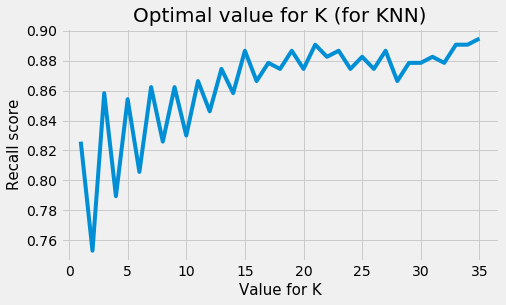

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.plot(range(1, 36), scores)
ax.set_title('Optimal value for K (for KNN)', size=20)
ax.set_xlabel('Value for K', size=15)
ax.set_ylabel('Recall score', size=15);

In [0]:
knn = KNeighborsClassifier(n_neighbors=21)  # k=21 looks the best
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
recall_score(y_test, y_pred)

In [0]:
knn = KNeighborsClassifier()  # baseline knn model
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
recall_score(y_test, y_pred)

estimators.append('KNN')
f1_scores.append(f1_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))

#### XGBoost

In [17]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

estimators.append('XGBoost')
f1_scores.append(f1_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))

recall: 0.8042973286875726
f1: 0.5603884280801134


#### Comparison dataframe


In [18]:
model_comparison = pd.DataFrame({'estimator': estimators, 'f1_score': f1_scores, 
              'recall_score': recall_scores})
model_comparison

,estimator,f1_score,recall_score
0,Logistic Regression,0.582293,0.880372
1,Decision Tree,0.627907,0.564460
2,Random Forest,0.715993,0.904762
3,AdaBoost,0.508475,0.818815
4,XGBoost,0.560388,0.804297


In [0]:
model_comparison.to_csv('drive/My Drive/data/model_comparison.csv', index=False)

#### Comparing results across estimators

In [3]:
model_comparison = pd.read_csv('drive/My Drive/data/model_comparison.csv')
model_comparison

,estimator,f1_score,recall_score
0,Logistic Regression,0.582293,0.880372
1,Decision Tree,0.627907,0.564460
2,Random Forest,0.715993,0.904762
3,AdaBoost,0.508475,0.818815
4,XGBoost,0.560388,0.804297


In [12]:
model_comparison.index.values
model_comparison.f1_score.values
model_comparison.estimator.values

array(['Logistic Regression', 'Decision Tree', 'Random Forest',
       'AdaBoost', 'XGBoost'], dtype=object)

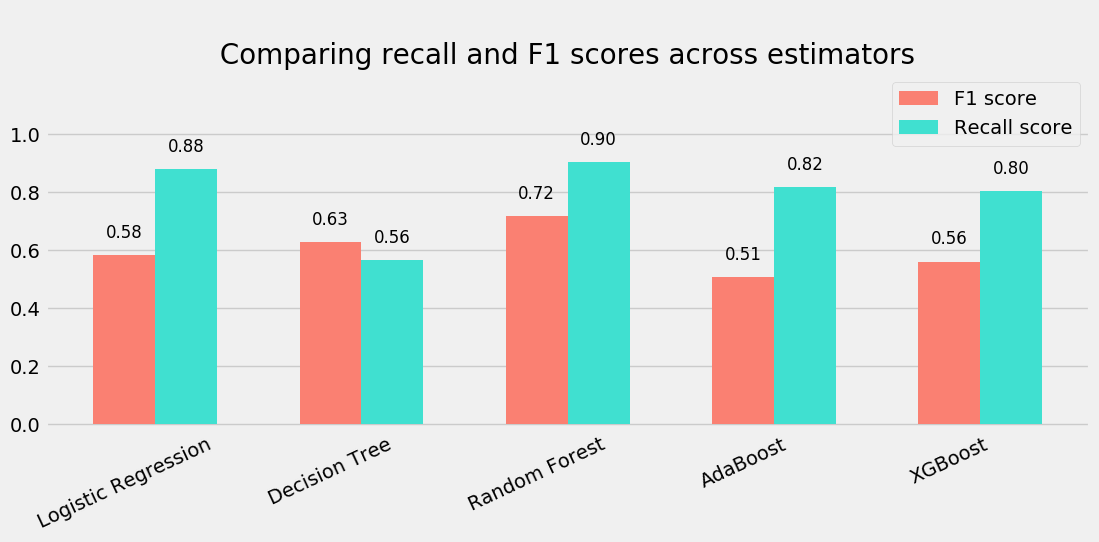

In [124]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.85, bottom=0.2)

data = model_comparison

bar_width = 0.3
r1 = model_comparison.index.values
r2 = [x + bar_width for x in r1]

ax.bar(r1, model_comparison.f1_score.values, color='salmon', label='F1 score',
      width=bar_width)
ax.bar(r2, model_comparison.recall_score.values, color='turquoise', label='Recall score',
      width=bar_width)

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 16),
                 textcoords='offset points')

ax.set_title('\n Comparing recall and F1 scores across estimators \n', size=20)
ax.set_ylim(-0.02, 1.1)
ax.grid(b=False, axis='x')
ax.set_xticks(range(0,5))
ax.set_xticklabels(model_comparison.estimator.values, rotation=25)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.1))
plt.savefig('drive/My Drive/data/model_comparison.png')

#### Hyperparameter tuning for Random Forest

In [0]:
pipe_rf_empty = Pipeline([('clf', RandomForestClassifier())])

# Set grid search params
params = [ 
  {'clf__n_estimators': [10, 30, 50],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[1, 3, 5, 10],  
   'clf__min_samples_split':[2, 3, 5, 10],
   'clf__random_state':[123]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf_empty,
            param_grid=params,
            scoring='recall',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best recall
print('Best recall:', gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123, total=   2.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123, total=   2.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123, total=   2.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=30, clf__random_state=123 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=30, clf__random_state=123, total=   3.8s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=30, clf__random_state=123 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 70.4min finished


Best recall: 0.9296357713174214

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 10, 'clf__random_state': 123}


In [0]:
best_rf = gs_rf.best_estimator_.steps[0][1]
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

Save the best random forest model as a `.pkl`

In [0]:
# joblib.dump(best_rf, 'drive/My Drive/data/best_rf_all_data_20190906.pkl', compress=1)

['drive/My Drive/data/best_rf_all_data_20190906.pkl']

Load best RF model

In [20]:
best_rf = joblib.load('drive/My Drive/data/best_rf_all_data_20190906.pkl')
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [21]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
recall_score(y_test, y_pred)

0.9332171893147503

In [25]:
confusion_matrix(y_test, y_pred)

array([[10648,  6567],
       [  115,  1607]])

Prettify confusion matrix

In [0]:
from sklearn.utils.multiclass import unique_labels

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, filepath,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    # save fig
    plt.savefig(filepath)
    
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[10648  6567]
 [  115  1607]]


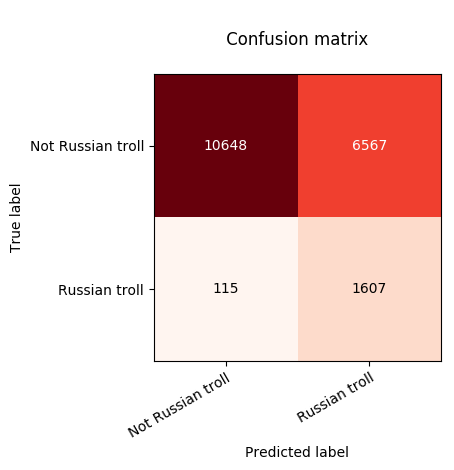

In [108]:
plt.style.use('default')
plot_confusion_matrix(y_test, y_pred, classes=['Not Russian troll', 'Russian troll'],
                      title='\n Confusion matrix \n',
                      filepath='drive/My Drive/data/confusion_matrix_rf.png')

Look at feature importances

In [49]:
feat_importance = pd.DataFrame((zip(X_train.columns, best_rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.4f' % x) 
feat_importance.sort_values('importance', ascending=False).head(10)

,feature_name,importance
810,pics_count,0.1828
264,trump,0.1381
806,pct_upper,0.1230
802,hashtags_count,0.1183
217,rt,0.0790
22,break,0.0656
774,#trump,0.0225
96,happy new,0.0222
801,mentions_count,0.0214
274,video,0.0192


#### Best Random Forest parameters from first grid search

In [0]:
rforest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=5,
                                 min_samples_leaf=1, min_samples_split=2
                                , random_state=123
                                )
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
recall_score(y_test, y_pred)

0.9332171893147503

In [0]:
confusion_matrix(y_test, y_pred)

array([[10648,  6567],
       [  115,  1607]])

In [0]:
scores_rforest = cross_val_score(rforest, X_train, y_train, cv=10, scoring='recall')
scores_rforest.mean()

0.9287463889348209

Save with pickle

In [0]:
joblib.dump(rforest, 'drive/My Drive/data/best_rf_trained_20190906.pkl')

['drive/My Drive/data/best_rf_trained2_20190906.pkl']

In [0]:
# filename = 'drive/My Drive/data/best_rf_trained2_20190906.pkl'
# with open(filename, 'wb') as f:
# 		pickle.dump(rforest, f, pickle.HIGHEST_PROTOCOL)

#### Try a vanilla Random Forest

In [0]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
recall_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8815331010452961

In [0]:
scores_rf = cross_val_score(rf, X_train, y_train, cv=10, scoring='recall')
scores_rf.mean()

0.8949994133865733

#### Logistic regression

In [0]:
lr = LogisticRegression(penalty='l2', )
scores_lr = cross_val_score(lr, X_train, y_train, cv=10, scoring='recall')
scores_lr.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.8854105318694643

In [0]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
recall_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8803716608594657

In [0]:
coef_list = lr.coef_.tolist()
coef_list = coef_list[0]
len(coef_list)
coef_df = pd.DataFrame({'features' : X_train.columns,
                       'coefs' : coef_list})

coef_df.sort_values(by = ['coefs'])

,features,coefs
167,new year,-7.758972
691,#law,-5.827620
518,#agw,-5.425641
706,#may,-5.196091
810,pics_count,-5.189977
508,#abcnews,-4.872174
720,#nra,-4.717378
547,#antifa,-4.663228
625,#elt,-4.388329
679,#job,-4.379887


#### XGBoost

In [0]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

recall: 0.8042973286875726
f1: 0.5603884280801134


#### Try logistic regression again

In [0]:
logreg = LogisticRegression(penalty='l2', random_state=123)
logreg.fit(X_train_combo, y_train)

c:\users\joey\learn-env2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
logreg.score(X_train_combo, y_train)

0.8884444444444445

In [0]:
logreg.score(X_test_combo, y_test)

0.8810751104565537

In [0]:
y_pred = logreg.predict(X_test_combo)

In [0]:
accuracy_score(y_test, y_pred)

0.8810751104565537

In [0]:
f1_score()

In [0]:
f1_score(y_test, y_pred)

0.5605442176870749

In [0]:
recall_score(y_test, y_pred)

0.8623481781376519

In [0]:
confusion_matrix(y_test, y_pred)

array([[2180,  289],
       [  34,  213]], dtype=int64)

In [0]:
coef_list = logreg.coef_.tolist()
coef_list = coef_list[0]
len(coef_list)
coef_df = pd.DataFrame({'features' : X_train_combo.columns,
                       'coefs' : coef_list})

coef_df.sort_values(by = ['coefs'])

,features,coefs
764,#tedcruz,-3.540458
518,#agw,-3.527994
688,#law,-3.446109
718,#nra,-3.376907
677,#job,-3.216085
702,#may,-3.015966
810,pics_count,-3.013007
548,#antifa,-2.816156
581,#charlottesville,-2.793105
652,#hillary,-2.698740


#### Decision Tree

In [0]:
dtree = DecisionTreeClassifier(max_depth=5, random_state=123)
dtree.fit(X_train_combo, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [0]:
dtree.score(X_train_combo, y_train)

0.7776111111111111

In [0]:
dtree.score(X_test_combo, y_test)

0.9374079528718704

In [0]:
y_pred = dtree.predict(X_test_combo)

In [0]:
accuracy_score(y_test, y_pred)

0.9374079528718704

In [0]:
f1_score(y_test, y_pred)

0.5952380952380952

In [0]:
recall_score(y_test, y_pred)

0.5060728744939271

In [0]:
confusion_matrix(y_test, y_pred)

array([[2421,   48],
       [ 122,  125]], dtype=int64)

#### Random Forest

In [0]:
rforest = RandomForestClassifier(n_estimators=100, random_state=123)
rforest.fit(X_train_combo, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [0]:
rforest.score(X_train_combo, y_train)

0.9969166666666667

In [0]:
rforest.score(X_test_combo, y_test)

0.9201030927835051

In [0]:
y_pred = rforest.predict(X_test_combo)

In [0]:
accuracy_score(y_test, y_pred)

0.9201030927835051

In [0]:
f1_score(y_test, y_pred)

0.6646058732612055

In [0]:
recall_score(y_test, y_pred)

0.8704453441295547

In [0]:
confusion_matrix(y_test, y_pred)

array([[2284,  185],
       [  32,  215]], dtype=int64)

In [0]:
# old test
list(X_train_content_feat.columns) == vocab  # check looks good

False

In [0]:
X_train = train.drop(['target'], axis=True)
X_test = test.drop(['target'], axis=True)
X_valid = valid.drop(['target'], axis=True)

y_train = train['target']
y_test = test['target']
y_valid = valid['target']

In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(37500, 27)
(7031, 27)
(2344, 27)
(37500,)
(7031,)
(2344,)


In [0]:
y_valid.value_counts()

0    1177
1    1167
Name: target, dtype: int64

## Old modeling code

In [0]:
X_train_clean = X_train.content_tokenized_lemma_joined.tolist()
len(X_train_clean)

40000

In [0]:
X_test_clean = X_test.content_tokenized_lemma_joined.tolist()
len(X_test_clean)

10000

#### Trying `CountVectorizer()`

In [0]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             max_features = 100,
                             ngram_range = (1, 3))

In [0]:
X_train_feat = vectorizer.fit_transform(X_train_clean).toarray()
X_train_feat.shape

(40000, 100)

In [0]:
X_test_feat = vectorizer.transform(X_test_clean).toarray()
X_test_feat.shape

(10000, 100)

In [0]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:5]

100


['america', 'american', 'amp', 'attack', 'bad']

#### Logistic Regression

In [0]:
logreg = LogisticRegression(penalty='l2')
logreg.fit(X_train_feat, y_train)

c:\users\joey\learn-env2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
logreg.score(X_train_feat, y_train)

0.69255

In [0]:
logreg.score(X_test_feat, y_test)

0.6899

In [0]:
coef_list = logreg.coef_.tolist()
coef_list = coef_list[0]

coef_df = pd.DataFrame({'features' : vectorizer.get_feature_names(),
                       'coefs' : coef_list})

coef_df.sort_values(by = ['coefs'])

,features,coefs
52,new year,-2.592763
83,tonight,-2.225184
77,thanks,-1.526609
58,play,-1.435818
26,happy new,-1.332883
21,game,-1.329322
98,year,-1.221104
76,thank,-1.151577
74,team,-1.005116
82,today,-0.927676


#### KNN

In [0]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feat, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
knn.score(X_train_feat, y_train)

0.6632

In [0]:
knn.score(X_test_feat, y_test)

0.628

In [0]:
scores = []
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_feat, y_train)
    scores.append(knn.score(X_test_feat, y_test))

In [0]:
plt.plot(range(1, 36), scores)  # k=26 looks like the best

#### Decision Tree

In [0]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_feat, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
dtree.score(X_train_feat, y_train)

0.75695

In [0]:
dtree.score(X_test_feat, y_test)

0.6844

#### Random Forest

In [0]:
rforest = RandomForestClassifier(n_estimators=100)
rforest.fit(X_train_feat, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rforest.score(X_train_feat, y_train)

0.75695

In [0]:
rforest.score(X_test_feat, y_test)

0.6915

#### Create a word vector

In [0]:
cv = CountVectorizer(max_features=27)
cv_t = cv.fit_transform(test_df.content_tokenized_lemma_joined)

In [0]:
len(cv.get_feature_names())

27

In [0]:
cv_t.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [0]:
pd.DataFrame(cv_t.toarray(), columns=cv.get_feature_names())

,break,call,day,get,go,happy,im,know,like,look,...,see,take,time,trump,us,video,want,watch,well,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
cv.get_feature_names()

['break',
 'call',
 'day',
 'get',
 'go',
 'happy',
 'im',
 'know',
 'like',
 'look',
 'make',
 'new',
 'one',
 'people',
 'right',
 'rt',
 'say',
 'see',
 'take',
 'time',
 'trump',
 'us',
 'video',
 'want',
 'watch',
 'well',
 'year']

## Old code

In [0]:
test_df[test_df.emojis_count > 0]

,author,content,publish_date,target,urls,mentions,hashtags,reserved_words,emojis,numbers,urls_count,mentions_count,hashtags_count,reserved_words_count,emojis_count,numbers_count
216139,thebillyprocida,"Take ""yes, we want YOU!"" for an answer 😃❤️",2017-12-31 17:30:17,0,[],[],[],[],"[😃, ❤]",[],0,0,0,0,2,0
81355,IMOGEENTR,#imo Putting the Fox back in the Hen House ......,2017-08-13 15:02:00,1,[https://t.co/O6Gw2GGgKi],[],"[#imo, #imos]",[],"[😂, 😂, 😂]",[],1,0,2,0,3,0
268148,eu_near,🇪🇺 🇷🇸 The 7th meeting of the Accession Confere...,2017-12-11 14:24:32,0,[http://www.consilium.europa.eu/en/press/press...,[],"[#Serbia, #Brussels]",[],"[➡, ➡, ➡]","[7, 2, 6, 30]",2,0,2,0,3,4
226045,neillycollins3,What was my best moment of 2017?..... this obv...,2017-12-31 17:10:26,0,[pic.twitter.com/n2lL38VXoW],[],[],[],"[⚽, 😂]",[2017],1,0,0,0,2,1
163808,LAZYKSTAFFORD,ooh cute vid ! ♥ https://t.co/mJLKS4GYvR,2015-03-18 12:23:00,1,[https://t.co/mJLKS4GYvR],[],[],[],[♥],[],1,0,0,0,1,0
269116,belgiummfa,"Since March of this year, there is a direct fl...",2017-11-08 01:54:41,0,"[http://bit.ly/2AsbKCH, pic.twitter.com/NUHlda...",[],"[#Brussels, #Mumbai, #BELIND2017]",[],[✈],[],2,0,3,0,1,0
214792,liamrudden,Although not sure I've been eager about anythi...,2017-12-31 17:32:55,0,[],[],[],[],"[😂, 😂, 😂]",[1975],0,0,0,0,3,1
193563,annaturdj,Happy new year from @heartibiza ❤️ #nye2018 #i...,2017-12-31 18:14:36,0,[https://www.instagram.com/p/BdYniLABdN_/],[@heartibiza],"[#nye2018, #ibizamusic]",[],[❤],[],1,1,2,0,1,0
232466,peopletv,Mochi the St. Bernard holds the #GuinnessWorld...,2017-12-31 17:00:01,0,"[https://people.tv/2BhxfKr, pic.twitter.com/8y...",[],"[#GuinnessWorldRecord, #PawsClaws]",[],[💕],[],2,0,2,0,1,0
213470,womenmgmt,Ready to #DAZZLE ✨ @feifeisunsun & jourdandunn...,2017-12-31 17:35:43,0,[https://www.instagram.com/p/BdYjJSrHvFE/],[@feifeisunsun],[#DAZZLE],[],[✨],[],1,1,1,0,1,0


Crazy example! By `COVFEFENATIONUS`

In [0]:
test_df[test_df.pct_upper == 0.7894736842105263]

,author,content,publish_date,target,urls,mentions,hashtags,reserved_words,emojis,urls_count,...,ques_marks,dollar_marks,pics,exclams_count,ques_marks_count,dollar_marks_count,pics_count,pct_upper,content_clean_tokenized_stopped,content_tokenized
123901,COVFEFENATIONUS,'@TaliaTirella @brianstelter @PTJusticeHLN @ja...,2017-11-30 08:28:00,1,[],"[@TaliaTirella, @brianstelter, @PTJusticeHLN, ...","[#FAKENEWS, #FAKENEWS, #FAKENEWS, #FAKENEWS, #...",[],[],0,...,[],[],[],6,0,0,0,0.789474,"[cnn, cnn, cnn, cnn, cnn, cnn]","[cnn, cnn, cnn, cnn, cnn, cnn]"
49275,COVFEFENATIONUS,'@CernovichNews @CNN @CNNI @CNNPolitics @CNNSi...,2017-11-30 04:14:00,1,[],"[@CernovichNews, @CNN, @CNNI, @CNNPolitics, @C...","[#FAKENEWS, #FAKENEWS, #FAKENEWS, #FAKENEWS, #...",[],[],0,...,[],[],[],6,0,0,0,0.789474,"[cnn, cnn, cnn, cnn, cnn, cnn]","[cnn, cnn, cnn, cnn, cnn, cnn]"


Treat emoticons and emojis

In [0]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [0]:
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [0]:
ex_tweet = tweets_all.content[100500]
# ex_tweet = tweets_all.content[3]
ex_tweet

In [0]:
ex_tweet = tweets_all[tweets_all.target == 0].content.values[7]
ex_tweet

Distribution of exclamation points

In [0]:
right_trolls.exclams_count.value_counts()

0     316847
1      63344
2      13964
3       3257
4       1253
6        622
5        295
7        168
8         28
9         28
10        16
13         7
15         5
12         4
14         4
11         3
20         2
22         1
18         1
32         1
Name: exclams_count, dtype: int64

An extreme example

In [0]:
right_trolls[right_trolls.exclams_count == 32].content.values[0]

'RT Laaskos: WE DID IT AMERICA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! https://t.co/qaGDPGqGAK'

#### Explore hashtags

In [0]:
right_trolls.hashtags_count.value_counts()

0     243122
1      75241
2      59643
3      11607
4       4556
5       2300
6       1218
8        881
7        724
9        274
10       153
11        88
12        31
14         6
13         3
16         1
15         1
23         1
Name: hashtags_count, dtype: int64

## Visualizations

#### Look at tweets over time

In [0]:
# generate_tweets_by_date(right_trolls, new_filepath='../../data/06_reporting/tweets_by_date_bots.csv')
# generate_tweets_by_date(verified_tweets, new_filepath='../../data/06_reporting/tweets_by_date_verified.csv')

In [0]:
tweets_by_date_bots = pd.read_csv('../../data/06_reporting/tweets_by_date_bots.csv', parse_dates=[0])
print(tweets_by_date_bots.shape)
tweets_by_date_bots.head()

(1182, 2)


,publish_date,num_of_tweets
0,2014-11-25,22
1,2014-11-26,32
2,2014-11-28,75
3,2014-12-01,11
4,2014-12-04,4


c:\users\joey\learn-env2\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  import sys
c:\users\joey\learn-env2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


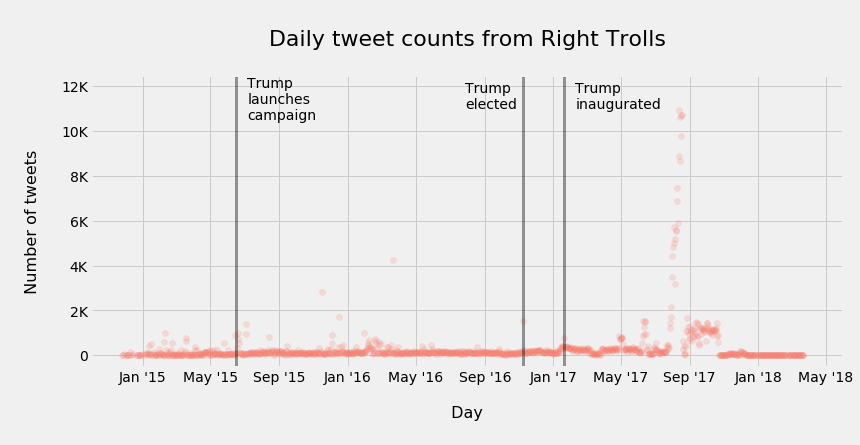

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.2, left=0.1)

# Converter to convert date strings to datetime objects
conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))

data = tweets_by_date_bots

# plt.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='salmon')
ax.set_title('\n Daily tweet counts from Right Trolls \n',
             size=22)
ax.set_xlabel('\n Day \n', size=16)
ax.set_ylabel('\n Number of tweets \n', size=16)
ax.set_ylim(-500, 12500)
ax.set_yticks(range(0, 14000, 2000))
ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])
ax.set_xlim(conv('2014-10-01'), conv('2018-06-01'))

month_yr_fmt = mdates.DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(month_yr_fmt)


plt.axvline(conv('2015-06-16'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2015-06-16') + 20, 10500, 'Trump\nlaunches\ncampaign')
plt.axvline(conv('2016-11-8'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2016-07-8') + 20, 11000, 'Trump\nelected')
plt.axvline(conv('2017-01-20'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2017-01-20') + 20, 11000, 'Trump\ninaugurated')
plt.savefig('../../results/img/00_tweets_by_date_bots.png')

In [0]:
tweets_by_date_verified = pd.read_csv('../../data/06_reporting/tweets_by_date_verified.csv', parse_dates=[0])
print(tweets_by_date_verified.shape)
tweets_by_date_verified.head()

(1110, 2)


,publish_date,num_of_tweets
0,2014-12-18,26
1,2014-12-19,18
2,2014-12-20,7
3,2014-12-21,10
4,2014-12-22,12


c:\users\joey\learn-env2\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  import sys


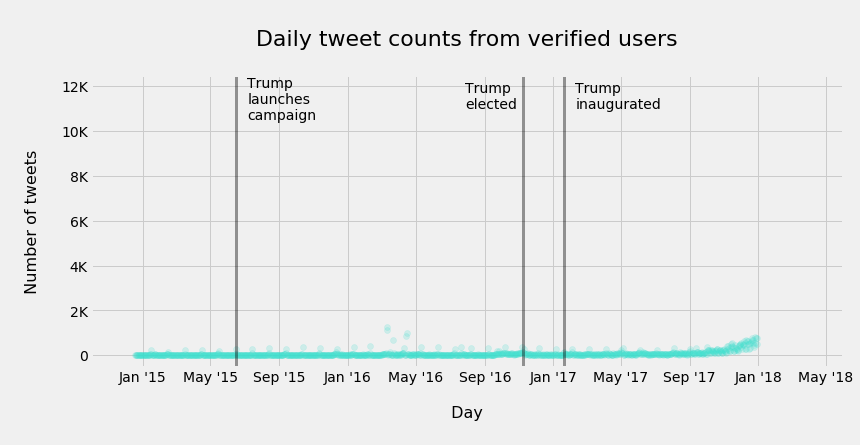

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.2, left=0.1)

# Converter to convert date strings to datetime objects
conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))

data = tweets_by_date_verified

# plt.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='turquoise')
ax.set_title('\n Daily tweet counts from verified users \n',
             size=22)
ax.set_xlabel('\n Day \n', size=16)
ax.set_ylabel('\n Number of tweets \n', size=16)
ax.set_ylim(-500, 12500)
ax.set_yticks(range(0, 14000, 2000))
ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])
ax.set_xlim(conv('2014-10-01'), conv('2018-06-01'))

month_yr_fmt = mdates.DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(month_yr_fmt)


plt.axvline(conv('2015-06-16'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2015-06-16') + 20, 10500, 'Trump\nlaunches\ncampaign')
plt.axvline(conv('2016-11-8'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2016-07-8') + 20, 11000, 'Trump\nelected')
plt.axvline(conv('2017-01-20'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2017-01-20') + 20, 11000, 'Trump\ninaugurated')
plt.savefig('../../results/img/01_tweets_by_date_verified.png')

#### Explore top hashtags

In [0]:
generate_hashtags_counts(right_trolls, new_filepath='../../data/06_reporting/hashtags_counts_bots.csv')

Processing all hashtags into one list...
...done.
List of all hashtags has length 262827
  Saved ../../data/06_reporting/hashtags_counts_bots.csv with shape (19232, 2)


In [0]:
top_hashtags_bots = pd.read_csv('../../data/06_reporting/hashtags_counts_bots.csv')
print(top_hashtags_bots.shape)
top_hashtags_bots.head(50)

(19232, 2)


,hashtag,counts
0,#top,6237
1,#MAGA,5426
2,#mar,4666
3,#IslamKills,3841
4,#topl,3820
5,#tcot,3355
6,#PJNET,3328
7,#amb,2749
8,#DemnDebate,2278
9,#th,2122


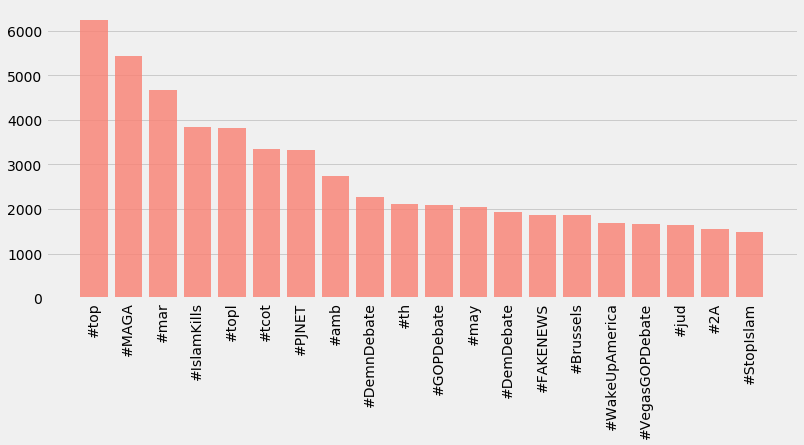

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
# plt.gcf().subplots_adjust(top=0.85, bottom=0.15)
# plt.gca().invert_yaxis()

data = top_hashtags_bots.set_index('hashtag').head(20)

ax.bar(data.index, data.counts, color='salmon', alpha=0.8)
ax.grid(b=False, axis='x')
ax.set_xticklabels(data.index, rotation=90);
# ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
# ax.set_title('\n Daily tweet counts from Right Trolls \n',
#              size=22)
# ax.set_xlabel('\n Day \n', size=16)
# ax.set_ylabel('\n Number of tweets \n', size=16)
# ax.set_ylim(-500, 12500)
# ax.set_yticks(range(0, 14000, 2000))
# ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])

#### Word clouds

In [71]:
tweets_all = pd.read_pickle('drive/My Drive/data/tweets_all_feats.pkl')
tweets_all.shape

(343582, 15)

In [0]:
words_all_trolls = tweets_all[tweets_all.target == 1]
words_all_verified = tweets_all[tweets_all.target == 0]

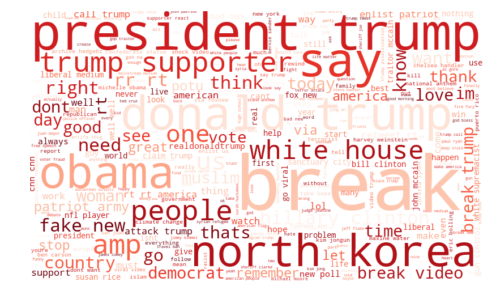

In [105]:
text_all_trolls = " ".join(words_all_trolls.content_tokenized_lemma_joined.tolist())

wordcloud = WordCloud(width=800, height=480, margin=0,
                      max_words=300, background_color="white",
                      colormap="Reds"
                       ).generate(text_all_trolls)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.savefig('drive/My Drive/data/02_word_cloud_trolls.png')

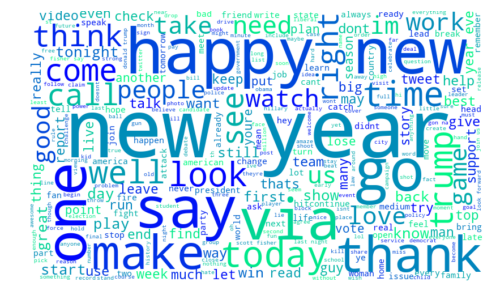

In [106]:
text_all_verified = " ".join(words_all_verified.content_tokenized_lemma_joined.tolist())

wordcloud = WordCloud(width=800, height=480, margin=0,
                      max_words=300, background_color="white",
                      colormap="winter"
                       ).generate(text_all_verified)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.savefig('drive/My Drive/data/03_word_cloud_verified.png')

In [86]:
text_all[:100]

'dave chappelle black life matter bad slogan ive ever heard enough enough votingtrump thought prayer '

In [0]:
wordcloud = WordCloud(width=480, height=480, margin=0,
                      max_words=300, background_color="white",
                      colormap="Blues"
                       ).generate(text_all)

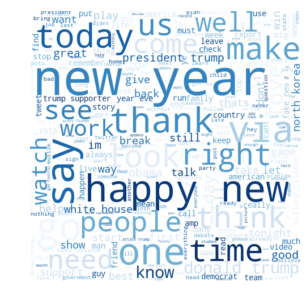

In [92]:
plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


#### See what's hogging memory

In [0]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_train', 233568058),
 ('X_test', 17621464),
 ('y_train', 576016),
 ('y_test', 43472),
 ('AdaBoostClassifier', 536),
 ('CountVectorizer', 536),
 ('Counter', 536),
 ('DecisionTreeClassifier', 536),
 ('FreqDist', 536),
 ('KNeighborsClassifier', 536),
 ('LogisticRegression', 536),
 ('MultinomialNB', 536),
 ('Pipeline', 536),
 ('RandomForestClassifier', 536),
 ('StandardScaler', 536),
 ('TfidfVectorizer', 536),
 ('WordNetLemmatizer', 536),
 ('XGBClassifier', 536),
 ('accuracy_score', 72),
 ('confusion_matrix', 72),
 ('f1_score', 72),
 ('generate_combined_features_X', 72),
 ('generate_emoji_vector_for_X', 72),
 ('generate_hashtag_vector_for_X', 72),
 ('generate_hashtags_counts', 72),
 ('generate_numeric_vector_for_X', 72),
 ('generate_tweets_by_date', 72),
 ('generate_unbalanced_X_and_y', 72),
 ('generate_word_vector_for_X', 72),
 ('recall_score', 72),
 ('train_test_split', 72),
 ('validate_train_test_split', 72),
 ('word_tokenize', 72),
 ('mdates', 44),
 ('np', 44),
 ('p', 44),
 ('pd', 

In [0]:
del(test_df)
del(train)
del(test)
del(validate)
del(X_train)
del(X_test)
del(X_valid)

In [0]:
for obj in [, train, test, validate, X_train, X_test, X_valid]:
    del(df)

#### Look at different author-level characteristics?

In [0]:
right_trolls.author.nunique()

622

# Old code

#### Hashtags used to pull verified tweets using `Twint`

Query the top 50 hashtags that are most frequently used by trolls (more than 1000 mentions)

In [0]:
top_hashtags_bots[top_hashtags_bots.counts > 1000]

,hashtag,counts
0,#MAGA,6817
1,#top,6580
2,#mar,4691
3,#PJNET,4665
4,#FAKENEWS,4306
5,#tcot,4042
6,#IslamKills,3854
7,#topl,3832
8,#amb,2749
9,#DemnDebate,2397


Also query the next 15 hashtags that seem like phrases

In [0]:
top_hashtags_bots[top_hashtags_bots.hashtag.str.contains('[A-Z]+', regex=True)][23:].head(30)

,hashtag,counts
57,#StopTheGOP,934
63,#Obama,878
64,#CruzCrew,870
75,#ISIS,819
78,#OscarHasNoColor,805
82,#BlackLivesMatter,797
97,#POTUS,674
98,#FakeNews,655
99,#DrainTheSwamp,653
102,#FeelTheBern,620


#### Tweepy testing - OLD

In [0]:
with open('../../conf/local/twitter_credentials.json', 'rb') as f:
    data = f.read()
    twitter_creds = json.loads(data)
api_key = twitter_creds['API_KEY']
api_secret_key = twitter_creds['API_SECRET_KEY']

In [0]:
# Replace the API_KEY and API_SECRET with your application's key and secret.
auth = tweepy.AppAuthHandler(api_key, api_secret_key)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

searchQuery = '#MAGA -filter:retweets filter:verified'  # this is what we're searching for
maxTweets = 1000# 10000000 # Some arbitrary large number
tweetsPerQry = 100  # this is the max the API permits
fName = '../../data/01_raw/tweets_test.csv' # We'll store the tweets in a text file.


# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 660 tweets
No more tweets found
Downloaded 660 tweets, Saved to ../../data/01_raw/tweets_test.csv
